# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 0.048662
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.194022 analytic: -0.194022, relative error: 1.546080e-09
numerical: 0.050070 analytic: 0.050070, relative error: 6.358772e-08
numerical: 0.093388 analytic: 0.093388, relative error: 9.750322e-09
numerical: 0.074138 analytic: 0.074138, relative error: 5.256374e-08
numerical: 0.034197 analytic: 0.034197, relative error: 5.623081e-08
numerical: -0.075807 analytic: -0.075807, relative error: 2.437763e-08
numerical: -0.054113 analytic: -0.054113, relative error: 9.263927e-08
numerical: 0.117846 analytic: 0.117846, relative error: 6.740542e-09
numerical: 0.012765 analytic: 0.012765, relative error: 1.505785e-07
numerical: 0.006173 analytic: 0.006173, relative error: 5.197495e-07
numerical: 0.083616 analytic: 0.085959, relative error: 1.381860e-02
numerical: 0.031346 analytic: 0.028924, relative error: 4.019294e-02
numerical: -0.043005 analytic: -0.051895, relative error: 9.367821e-02
numerical: -0.058941 analytic: -0.059268, relative error: 2.767303e-03
numerical: -0.009926 ana

In [10]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 4.866182e-02 computed in 0.006461s
(500, 10)
500
vectorized loss: 2.411592e+00 computed in 0.011374s
Loss difference: 2.362930
Gradient difference: 370.606763


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        sm=Softmax()
        sm.train(X_train,y_train,learning_rate=lr,reg=reg,num_iters=400)
        train_y=sm.predict(X_train)
        train_acc = np.mean(y_train == train_y)
        val_y=sm.predict(X_val)
        val_acc = np.mean(y_val == val_y)
        results[(lr,reg)]=[train_acc,val_acc]
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = sm
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[[ 1.51526207e-03  5.08934881e-06  2.27393852e-03 ...  1.52604520e-04
   1.35979420e-04  1.94769837e-04]
 [ 4.82511658e-06 -4.99952993e-03  3.85533630e-03 ...  4.14313052e-05
   9.89699219e-04  1.41511161e-06]
 [ 2.85377885e-04  8.81751261e-05  4.52633810e-04 ...  1.29219162e-03
   4.88808588e-04 -4.89635665e-03]
 ...
 [ 7.64431552e-07  5.94792327e-08  2.24833610e-06 ...  2.02367898e-04
  -4.93096500e-03  4.91865912e-06]
 [ 1.15698180e-03  5.24702087e-06 -1.79353945e-03 ...  1.72972824e-04
   6.55095819e-05  1.70021687e-04]
 [ 4.75002757e-04  1.36701030e-05  5.65970422e-04 ...  4.24369662e-06
   4.48592896e-06 -1.11490189e-03]]
[[ 8.27333386e-05  2.12379020e-06  4.77201680e-03 ... -4.99497951e-03
   1.04247761e-05  2.23461459e-05]
 [ 6.20971942e-07  1.50267348e-05  2.03349999e-05 ...  1.49145361e-04
   1.43314860e-04  4.44776057e-05]
 [ 3.26379270e-05  6.00135434e-04  2.75376028e-04 ... -4.99903582e-03
   3.82521786e-06  1.28250743e-04]
 ...
 [ 7.17975551e-07  1.01153498e-04  3.9051523

[[ 9.40954410e-06 -4.99857972e-03  1.45218258e-07 ...  1.39887141e-03
   2.30267234e-07  2.55512193e-05]
 [ 4.40973979e-04  2.97581672e-04  7.75430346e-04 ...  9.57576814e-04
   4.02506220e-04  2.93344389e-04]
 [ 1.88424781e-05  7.77951531e-04  8.68316025e-05 ...  1.89608391e-04
   3.97616249e-04 -4.97567554e-03]
 ...
 [ 1.61989323e-04  2.05028899e-03  5.65152883e-04 ...  5.39461649e-04
   1.77647553e-05  3.38790671e-04]
 [ 1.32572481e-04  1.26695834e-03  3.90872145e-04 ...  4.56541952e-05
   3.58158563e-06  1.75462303e-05]
 [ 7.56661672e-07 -4.93782664e-03  5.80901567e-05 ...  1.04991045e-04
   2.33009637e-04  1.76696436e-04]]
[[ 1.85010342e-03 -4.90246852e-03  3.07296739e-04 ...  7.72726777e-04
   4.73262002e-04  1.21202117e-04]
 [ 6.05120476e-04  2.21568370e-03  1.76440704e-06 ...  5.89120865e-04
  -4.99206871e-03  3.29787981e-04]
 [ 6.52466844e-04  1.05540446e-04  3.92711220e-04 ...  1.49993886e-04
  -1.57316510e-03  2.19791247e-04]
 ...
 [ 1.47581080e-04  3.22282852e-08  4.5560092

[[ 1.09990957e-05  3.88205469e-05  6.49357266e-04 ... -4.96517148e-03
   1.12621155e-04  6.30777994e-05]
 [ 1.81837587e-05  4.54742127e-05 -4.84986825e-03 ...  4.48033408e-05
   5.35387611e-05  3.94627013e-04]
 [ 7.82736266e-04  5.61422883e-04  1.06788621e-05 ...  1.07350761e-03
   1.03426376e-06  1.22237265e-04]
 ...
 [ 1.30747047e-04  9.70823067e-05  1.30262648e-04 ...  7.51401491e-05
  -3.23433105e-03  1.32706451e-04]
 [ 1.35336858e-04  2.41385408e-05  2.44790558e-04 ...  1.39911921e-03
   3.55659282e-04  2.76240134e-06]
 [ 9.20910059e-05  2.28111171e-03 -4.99669565e-03 ...  5.50887613e-05
   4.50191104e-04  1.78764962e-04]]
[[ 1.49837692e-06  1.19669540e-05  4.79549773e-03 ...  4.05250010e-06
   1.88743483e-05  3.99948618e-06]
 [ 3.35336589e-03  8.14793858e-06 -4.47289634e-03 ...  4.35369299e-04
   2.35501944e-04  3.93083986e-06]
 [ 6.02755396e-05  1.87274769e-03  9.96387398e-06 ... -4.91828253e-03
   5.53847884e-05  2.48838412e-03]
 ...
 [ 4.27770657e-04  2.14380338e-05 -4.9287201

[[ 2.25422082e-05  7.81021562e-04  2.79306835e-05 ...  1.84289084e-05
   6.97520038e-07  3.58390617e-03]
 [-4.97990135e-03  4.49718853e-03  6.43111847e-06 ...  2.92381723e-05
   3.22861446e-06  2.69236920e-04]
 [ 7.66546935e-06  1.52290722e-04  2.56808338e-07 ...  4.50065345e-04
   6.31333152e-05 -4.54888052e-03]
 ...
 [ 1.99844319e-04  1.35460893e-03  9.38188205e-04 ...  2.53276859e-04
   4.01201031e-04  1.75980198e-04]
 [ 1.35709348e-04  1.27594719e-03  1.92007070e-04 ...  2.94736481e-04
   4.60204427e-05 -3.60305900e-03]
 [ 1.19106897e-04  2.58966326e-06  1.51495570e-05 ...  2.68512713e-04
   7.22279268e-05  3.68288519e-05]]
[[ 4.98307890e-05  1.16550824e-04  1.63042069e-05 ...  1.65338056e-04
   7.54177335e-05  1.74856142e-03]
 [-4.27609050e-03  7.95531605e-04  8.53296919e-05 ...  1.85032760e-04
   8.95968629e-04  6.82688805e-04]
 [ 6.00686302e-05  9.47778568e-05  1.86539512e-03 ...  1.29406008e-04
   7.45082327e-06 -4.99681711e-03]
 ...
 [ 2.91385709e-03  5.34473195e-04  4.4824000

[[ 5.03158817e-04  7.17692194e-04  1.73084848e-03 ...  6.24501077e-05
   2.26323907e-04  3.91145832e-04]
 [ 7.48965180e-04  6.28469234e-04  4.34430625e-04 ...  3.09237497e-05
  -4.97687174e-03  1.49810928e-04]
 [ 5.81739680e-04  5.16144407e-05  3.35948337e-04 ...  1.99064234e-03
   4.43795202e-04  7.19809035e-05]
 ...
 [ 1.99616941e-05  1.12884759e-04  6.03842135e-06 ...  4.01325883e-04
   6.98813959e-05  3.93441639e-03]
 [ 1.17679508e-05  9.15676636e-04  1.05336350e-03 ...  1.08429672e-03
   1.96894442e-04 -4.98811057e-03]
 [ 2.60822065e-04  7.52248919e-04  2.91063435e-04 ...  3.40205690e-05
   2.23029482e-04  2.50460205e-03]]
[[ 3.75681083e-04  2.08529329e-04 -4.94749183e-03 ...  1.98694221e-04
   1.41082146e-03  1.54233763e-03]
 [ 5.01146738e-04  1.42402721e-05  2.63110015e-05 ...  1.32075880e-03
   8.43597852e-06  2.46079208e-03]
 [ 8.13005170e-05  2.11417176e-04  6.00823898e-05 ...  2.20305403e-05
   6.87124523e-05  8.02089005e-04]
 ...
 [ 1.79303016e-03  4.62584800e-05 -4.9017478

[[ 3.40354120e-05  3.11015526e-04  1.36903926e-03 ...  1.12011572e-04
   1.25325479e-04  5.38875275e-05]
 [-4.61608495e-03  3.06956539e-04  3.06674294e-04 ...  7.01899552e-05
   2.14387617e-03  3.48782042e-04]
 [ 5.47965441e-05  7.47418433e-04  1.32554655e-04 ...  1.63961752e-04
   2.21497308e-04  8.86848130e-06]
 ...
 [ 1.45699023e-03  5.65292701e-04  5.85177439e-04 ...  1.96190378e-04
   9.34344000e-05  4.26446167e-04]
 [ 1.36259158e-03  1.59454945e-04  2.09938786e-04 ...  2.63882765e-04
  -4.65733982e-03  4.50264793e-05]
 [ 8.21344515e-05  1.30302737e-04  1.23142137e-07 ...  5.07364809e-06
   3.14794861e-06  1.28484265e-04]]
[[ 5.28795127e-05 -4.79917779e-03  4.42375598e-04 ...  7.06362084e-05
   2.94176202e-04  1.64600025e-04]
 [ 2.44273275e-04  2.55417771e-04 -4.98945343e-03 ...  2.34682711e-04
   3.71453951e-03  4.77578472e-04]
 [ 8.00546193e-04  9.57871200e-05  3.09626766e-04 ...  1.69501215e-04
   1.57635429e-04  1.70835270e-03]
 ...
 [ 3.34246088e-04  2.28615668e-04  1.7964556

[[ 4.95686518e-06  9.85743220e-04  2.26613501e-04 ...  7.35872683e-04
   2.86252269e-05 -3.45431498e-03]
 [ 4.81960459e-04  1.55440868e-03  2.93262890e-05 ... -4.21203613e-03
   3.59011596e-05  1.10759552e-03]
 [ 2.51715131e-03  3.01985064e-04  7.09629666e-06 ...  1.08233271e-03
   3.62542383e-04  4.54832673e-04]
 ...
 [ 1.25546156e-04  1.84477272e-04  1.28965333e-03 ...  4.59189525e-04
   4.00919109e-05  2.59336313e-04]
 [ 8.51878174e-04  4.73031990e-05  7.66454767e-06 ...  1.44522665e-05
  -1.33951746e-03  3.71733496e-04]
 [ 5.36474468e-04  3.11686980e-04 -4.62311492e-03 ...  4.62740253e-04
   7.96214926e-04  1.65569871e-04]]
[[ 1.15826612e-04  7.54670197e-04  9.87118617e-05 ...  5.33150744e-05
   4.54774800e-05  1.08698412e-04]
 [ 1.38412692e-04  2.56807600e-04  2.17071387e-04 ...  6.85766718e-04
   2.82645652e-04  4.38009770e-04]
 [ 8.86791385e-05  5.68606986e-04  1.04861634e-03 ...  1.42509931e-03
   1.43743665e-04  4.44797392e-04]
 ...
 [ 5.79607162e-04  3.17028718e-04  1.5084283

[[ 3.19917933e-05  5.69280264e-05  1.00583029e-03 ...  5.52349566e-04
   2.73681492e-04  5.13856959e-04]
 [ 7.21169131e-04  1.82156633e-03  1.75301954e-04 ...  1.85797282e-04
  -4.33791323e-03  8.41460543e-04]
 [ 2.56454183e-03  2.76979522e-04  3.83511675e-05 ...  9.15400969e-05
   1.20693830e-03  1.61100065e-04]
 ...
 [ 4.50682189e-04  3.22850830e-03  1.72974808e-04 ...  1.96290793e-04
   1.37024684e-04  4.07288411e-04]
 [ 3.67817638e-05  7.50854827e-05  3.99996187e-04 ...  1.15387666e-03
   1.28176335e-05  1.11605544e-04]
 [ 3.97419146e-04  8.14278757e-04  2.09485540e-03 ...  1.93352505e-04
   7.90789636e-05  9.45383286e-05]]
[[-4.45540392e-03  2.24052287e-04  1.48425924e-04 ...  3.03355289e-05
   2.19726013e-03  1.02565298e-03]
 [-4.67080674e-03  3.14029304e-04  1.57418904e-03 ...  6.95190397e-04
   4.48617152e-04  1.95969808e-04]
 [ 2.06399099e-04  2.90864436e-04  1.67133437e-04 ...  2.57066490e-04
   1.01779794e-04  3.31408585e-04]
 ...
 [ 5.25855632e-05  1.88772791e-04  1.2283297

[[ 5.65486768e-04  6.40821410e-04  1.74523924e-04 ...  9.06775312e-05
   2.19136543e-03 -3.96935246e-03]
 [ 7.53551174e-04  1.22834937e-04  2.68639503e-04 ... -4.28325760e-03
   2.54359359e-03  5.65662909e-05]
 [ 1.20827652e-03  2.20486317e-04  1.66169228e-04 ...  8.53132236e-05
  -2.27171197e-03  8.41506231e-05]
 ...
 [ 1.65809271e-04  2.51158807e-05  2.16648395e-03 ...  5.93672219e-04
   4.88585815e-05  7.81963724e-04]
 [ 7.18760970e-04  2.14289782e-04  7.01921830e-05 ...  1.47804780e-04
   1.91846993e-04 -4.13374629e-03]
 [ 3.41895474e-04  7.70289729e-04  7.52023897e-05 ...  4.79391140e-05
   2.39554123e-04  3.74514595e-04]]
[[ 7.82842985e-05  5.59493012e-04  4.12436284e-04 ...  9.16859954e-04
   6.92742794e-05  3.10775824e-04]
 [ 1.28999832e-05  1.33757934e-04  4.72237447e-04 ...  1.34178264e-03
   3.90971834e-05  6.47841380e-05]
 [ 3.98061496e-05  1.26541425e-04  1.64123676e-04 ...  2.50534452e-04
   6.08944948e-05  1.03233863e-03]
 ...
 [ 1.12621865e-03  2.60265869e-04 -4.3620447

[[ 1.69456541e-04  3.89784572e-04  2.06109815e-04 ...  1.62088175e-04
   2.33831402e-05  8.87203636e-05]
 [ 1.24507710e-04  1.97827501e-05  1.04730029e-04 ... -3.02966263e-03
   3.22361961e-05  9.10348848e-04]
 [-2.84834610e-03  1.82590502e-04  1.30628137e-04 ...  7.72954831e-05
   1.30052576e-03  2.14790240e-04]
 ...
 [ 9.53693703e-05  2.65719392e-04  1.78411239e-04 ...  8.75679875e-04
   5.93077142e-05  9.28344511e-05]
 [ 9.19256538e-05  1.51705743e-04  1.88345699e-03 ...  3.73281660e-04
   1.01079111e-04  4.50212918e-05]
 [ 1.27270995e-03  3.04265958e-04 -4.88859674e-03 ...  5.85432733e-04
   1.52360384e-03  4.72089398e-04]]
[[ 1.11851711e-04  8.80193934e-04  5.38849996e-04 ...  1.39850171e-04
   3.30018350e-04  5.80390216e-04]
 [ 6.37615921e-04  1.89984354e-04  2.01529076e-04 ...  3.49649331e-04
   5.50210231e-05  1.12345925e-04]
 [ 1.39866405e-04  1.15064877e-04 -4.45060330e-03 ...  1.17543122e-03
   1.63681955e-04  3.59860000e-04]
 ...
 [ 2.38052145e-04 -3.40071126e-03  8.2627367

[[ 1.49534104e-03 -4.80125978e-03  2.74104159e-04 ...  5.37219694e-04
   3.12576092e-04  9.34984869e-04]
 [ 1.68987829e-04  5.21066355e-04  6.38588741e-04 ...  1.06629465e-03
   4.32777974e-05 -3.83229679e-03]
 [ 1.81171140e-04  1.18569451e-04  1.88266447e-04 ...  1.49682082e-04
   2.80078981e-04  1.14528133e-03]
 ...
 [ 4.01897133e-04  6.63584139e-04  2.67712057e-04 ...  1.36550869e-04
   4.34586864e-04  9.29298908e-04]
 [ 2.84668474e-04  5.35377971e-04  2.39061404e-04 ...  1.32652354e-04
   7.08560450e-04  4.36275233e-04]
 [ 5.98978095e-04 -4.80107901e-03  7.21374550e-04 ...  6.84283185e-05
   7.71956596e-05  1.23490833e-04]]
[[ 1.52678429e-03  5.80498029e-04  2.24435433e-04 ...  3.75126514e-04
   3.23309187e-04 -4.18070400e-03]
 [ 8.41334385e-05  1.07586376e-03  4.11492656e-05 ...  9.89515303e-05
  -3.89836316e-03  2.26548669e-03]
 [-4.95448139e-03  1.14882958e-04  3.14694653e-04 ...  4.61597515e-04
   1.48947522e-05  4.72630665e-05]
 ...
 [ 3.75995546e-04  5.01927591e-04  5.8942068

[[ 2.65025670e-04  2.77219651e-04 -4.28018685e-03 ...  4.40622665e-04
   1.99608728e-04  6.11501404e-04]
 [ 1.67765799e-04  1.10711668e-03  3.33577339e-04 ...  1.04276948e-04
  -4.52824246e-03  8.73933872e-05]
 [ 1.59182059e-04  4.49716594e-04  1.06447734e-03 ...  9.52508408e-04
   7.58388326e-05  1.95491747e-04]
 ...
 [ 5.70194157e-05  1.82348775e-04 -4.13961073e-03 ...  5.75026391e-04
   1.73238199e-04  3.91211468e-05]
 [ 9.46938719e-04  1.03155168e-04  3.63330517e-04 ... -4.85599696e-03
   8.83331853e-04  7.98937377e-05]
 [ 5.63445360e-05  7.03163862e-04  2.49740524e-04 ...  1.76460694e-03
   6.67441152e-05  1.07960241e-03]]
[[ 5.61875123e-04  1.76594317e-04  4.84630095e-04 ...  6.80424279e-04
   7.01308458e-04  1.10636832e-03]
 [ 1.72373137e-04  3.03171806e-04  9.85453165e-04 ...  4.45999611e-04
   9.14554499e-05  1.40957528e-04]
 [ 1.10288399e-04  1.93273256e-04  1.27332685e-03 ... -4.33997576e-03
   1.47105472e-04  1.05630268e-04]
 ...
 [ 6.48183011e-04  7.41773269e-04  6.4338002

[[ 2.21948521e-06  1.02572412e-04  2.07717068e-03 ...  5.22502498e-05
   1.19806924e-04  1.62060149e-05]
 [ 2.51222321e-05  3.31571818e-04  3.97338638e-03 ...  6.28243513e-05
   1.27230033e-04  1.60653588e-04]
 [ 1.26939978e-04  1.79290878e-08  2.31811165e-06 ...  4.88812502e-07
   3.08833898e-05  6.94789974e-09]
 ...
 [ 2.12756173e-05  2.37902256e-03  3.72462213e-04 ...  3.80870853e-07
   9.57808552e-06  1.02510286e-05]
 [ 1.44541889e-05  6.01022911e-04  4.28948793e-03 ...  1.42497850e-05
   1.15735903e-06 -4.95130511e-03]
 [ 1.45714571e-04  1.30413423e-05 -4.95667472e-03 ...  8.57431010e-04
   1.14688239e-03  1.39669951e-03]]
[[ 3.21017634e-03 -4.94081312e-03  1.61306822e-04 ...  2.55082039e-05
   6.63100672e-04  1.14653657e-05]
 [-4.96459446e-03  3.15706154e-03  1.12243101e-03 ...  4.12107266e-05
   2.39172202e-04  1.27099563e-05]
 [ 1.58555488e-03  4.42593079e-04  6.74766923e-04 ...  7.09537856e-05
   1.10634254e-04  5.64704320e-04]
 ...
 [ 2.80423509e-06  2.64938045e-03  2.3734298

[[ 4.90468232e-05  3.36225805e-06  4.02199589e-07 ...  1.47750602e-03
   1.00369370e-06  3.15474979e-03]
 [-4.79174920e-03  8.03754607e-04  3.49016947e-04 ...  3.23560340e-04
   1.64698235e-04  8.61080270e-05]
 [ 1.66088412e-05  3.05382003e-04  1.27001904e-03 ...  3.13369010e-04
   2.63346843e-03 -4.85832658e-03]
 ...
 [ 2.30304083e-06 -1.07056041e-03  4.57976128e-05 ...  2.57493559e-05
   2.48306013e-06  1.54608965e-04]
 [ 9.65805805e-06  3.65805745e-05  1.82835026e-05 ...  5.08571243e-05
   3.93506719e-05  9.42849515e-05]
 [ 9.61877574e-07  1.43561777e-06  5.92009288e-07 ... -4.99203516e-03
   7.82562170e-04  4.11799011e-03]]
[[ 6.97970352e-06  1.11659905e-05  2.71523568e-04 ...  1.31844463e-05
   7.75152903e-05  6.16051277e-06]
 [ 6.02692011e-06  3.82511629e-06  4.44603203e-03 ... -4.99789666e-03
   6.61741125e-05  1.51621945e-06]
 [ 4.04586262e-04  6.28338358e-05  1.13670916e-04 ...  1.92100293e-04
   1.05823173e-04  1.85228815e-04]
 ...
 [ 1.47941125e-04 -4.87880946e-03  1.8948957

[[ 3.37873177e-04  2.00984255e-04  3.81237961e-04 ...  3.93137479e-04
   5.78952539e-05  1.02319221e-04]
 [-3.62954158e-03  3.20628387e-05  1.54529857e-04 ...  8.28312044e-04
   4.55540616e-04  1.02940083e-04]
 [-4.94141880e-03  4.85225071e-04  2.23573980e-03 ...  2.11674287e-05
   8.53118891e-04  5.69635643e-04]
 ...
 [ 5.56522998e-05  1.20514712e-03  1.41600266e-04 ...  9.09120081e-05
   7.28637586e-04 -2.40920345e-03]
 [ 5.33693336e-04  6.69630986e-04  7.44395781e-04 ...  5.75303756e-04
   3.12295007e-04  8.68108966e-04]
 [ 1.13992936e-03  1.91326441e-03  2.61133137e-05 ...  9.85380861e-05
   7.84865203e-05 -3.64508388e-03]]
[[ 2.38673081e-05  7.02446271e-06  5.91490025e-06 ...  8.86391608e-04
   8.14227769e-05  1.27871221e-05]
 [ 7.11953512e-04  4.78333869e-05  8.09776494e-04 ...  2.41866262e-05
   2.18318602e-04 -3.91340298e-03]
 [ 2.20095787e-05 -3.81723939e-03  2.89844026e-04 ...  1.14220038e-04
   6.67701732e-04  1.20637891e-03]
 ...
 [ 1.06097946e-03  8.30255905e-06  1.5080173

[[-2.92504618e-03  1.92040886e-05  4.70875495e-04 ...  1.22522917e-04
   1.78224400e-03  2.46291492e-04]
 [ 5.67323297e-04 -4.65303470e-03  1.37264476e-04 ...  1.24527817e-03
   1.48191042e-04  3.23165316e-04]
 [ 3.29477914e-05  4.69677690e-04 -4.25317184e-03 ...  2.34315598e-05
   1.16082408e-03  6.56453931e-05]
 ...
 [ 2.48715295e-03  1.69156320e-05  1.41234214e-04 ...  5.61086158e-05
   2.98051067e-04  8.14807748e-05]
 [ 9.16530578e-04  9.87193882e-04  8.61437871e-04 ... -4.18427005e-03
   7.54755805e-05  1.39052242e-04]
 [ 2.83400783e-04  1.26201061e-03  3.06839587e-04 ...  5.97012559e-05
   5.21092606e-04  1.30072345e-03]]
[[ 3.63583458e-04  9.02061501e-04  4.33511116e-04 ...  8.59587592e-04
   2.47595558e-04  1.09815716e-03]
 [ 3.51486018e-04 -4.82050263e-03  1.51072814e-04 ...  2.61991823e-03
   3.53271276e-05  1.10669238e-04]
 [ 4.35588318e-04  3.21263687e-04 -4.53979500e-03 ...  1.68114251e-04
   6.42806619e-04  2.22047090e-03]
 ...
 [-4.48884101e-03  7.31947410e-05  5.2210808

[[ 8.05195808e-05  7.94734676e-04 -4.97444731e-03 ...  6.92353173e-04
   6.52869624e-05  2.84509921e-04]
 [-4.94903043e-03  3.73124106e-05  1.46145687e-04 ...  7.53371892e-04
   8.64769375e-04  1.83820106e-04]
 [ 5.73452484e-05  1.06931121e-03  2.56143944e-04 ...  3.14544015e-04
   4.10023519e-05  1.21757160e-04]
 ...
 [ 2.73427842e-04  6.28095993e-05  1.23853342e-04 ...  1.45286266e-04
   6.06433934e-04  9.00845197e-06]
 [-4.98125785e-03  2.48924440e-03  9.57771819e-05 ...  3.99236040e-04
   2.39579503e-04  6.48536240e-04]
 [ 1.45022712e-03 -4.98230892e-03  1.71673000e-03 ...  3.50994687e-05
   5.86546238e-04  1.32943760e-04]]
[[ 2.11835222e-04  7.14376102e-04 -4.56352711e-03 ...  8.18692580e-05
   3.35888116e-04  1.09018877e-04]
 [ 3.81145817e-04  4.16053694e-04  2.14556394e-04 ...  1.07611251e-03
   2.69376992e-04  1.55436045e-03]
 [ 8.09583750e-04  6.17023241e-04  3.15007560e-04 ...  1.98378477e-03
   2.17973049e-04 -4.84773840e-03]
 ...
 [ 5.20348142e-04  1.12239254e-04  7.2849102

[[-1.94124758e-03  1.94234666e-04  2.88220239e-04 ...  1.46695909e-04
   4.34291527e-04  8.97393498e-05]
 [ 2.18641406e-04 -4.58057613e-03  9.87102224e-04 ...  4.78312949e-04
   3.61613327e-04  1.30296218e-03]
 [ 3.73088989e-04  7.90310438e-04  4.05201101e-04 ...  1.43981373e-04
   1.33050422e-03 -4.25911840e-03]
 ...
 [ 2.54504323e-03 -4.68921555e-03  2.36740891e-04 ...  2.59315769e-04
   6.92456171e-05  1.83624028e-04]
 [ 9.99782901e-04  4.80622433e-04  3.15602521e-04 ...  2.84744839e-04
   5.15000646e-04 -4.86046864e-03]
 [-4.61093627e-03  4.64282067e-05  1.09686784e-03 ...  1.02870896e-03
   7.69224095e-04  2.11765031e-04]]
[[ 2.61533579e-04  4.16293650e-04  9.91455516e-04 ... -3.71484238e-03
   8.90791186e-04  4.23858291e-04]
 [ 1.18063695e-04  3.10879468e-04  1.98518726e-04 ...  1.90554163e-04
   2.57375052e-04  2.34968897e-04]
 [ 4.51879453e-05 -4.02152224e-03  1.01883806e-04 ...  1.09548064e-04
   1.71983100e-04  3.77495054e-05]
 ...
 [ 4.42708877e-04  1.23748162e-04  7.2491904

[[ 6.24319060e-05  3.43861853e-04  1.05637820e-03 ...  3.94912046e-04
   1.74808352e-04  4.17203852e-04]
 [ 5.05543503e-04  4.56800352e-04  8.72599136e-04 ...  2.29317957e-04
  -3.92947515e-03  7.41691536e-04]
 [ 3.83238350e-04  9.37541425e-04 -4.47381284e-03 ...  4.00428795e-04
   6.90205812e-04  3.70658209e-04]
 ...
 [ 5.20002235e-04  2.35413600e-04  3.08320143e-04 ...  2.02804504e-04
   3.64059517e-04  2.49861822e-04]
 [ 4.59858537e-04  2.36178560e-04  3.03412170e-04 ...  6.46558600e-04
   6.53369045e-05  3.89421027e-04]
 [ 6.65314263e-04  3.16479805e-04  6.17488275e-04 ...  1.07780870e-03
   3.49120492e-04  1.89515928e-04]]
[[ 1.07555831e-03 -4.93713629e-03  8.99420202e-04 ...  2.98144446e-04
   6.89104291e-04  1.58587384e-04]
 [ 8.55436709e-05  7.58007444e-04 -4.67332350e-03 ...  5.00570683e-04
   5.88747350e-05  1.00292592e-04]
 [ 2.16366702e-04  1.85037934e-04 -4.64371080e-03 ...  1.08024013e-04
   5.28008423e-05  3.64288439e-04]
 ...
 [ 3.69316907e-04  4.11157355e-04  2.4567121

[[-4.32654553e-03  7.94623377e-04  3.02136957e-04 ...  2.34336772e-04
   1.52717703e-03  4.29254655e-04]
 [ 2.06146427e-04  7.01128835e-04 -4.52876033e-03 ...  8.48371359e-04
   4.07660299e-04  1.93876640e-04]
 [ 1.00571266e-04  3.24623924e-04  2.24029733e-04 ...  3.67313210e-04
   1.44876674e-04  1.71769360e-04]
 ...
 [ 6.58708018e-04 -4.21685209e-03  6.12783033e-05 ...  1.90437603e-04
   4.17667027e-04  1.90617981e-03]
 [ 4.84343418e-04  3.74341724e-04  1.43939233e-04 ...  4.52574676e-04
  -3.72939069e-03  7.16262889e-04]
 [ 3.43880070e-04  4.86137003e-04  3.52527492e-04 ...  5.86570376e-04
  -4.22641290e-03  4.65490811e-04]]
[[ 0.00018438  0.0006519   0.00031059 ...  0.00047834  0.00013588
   0.00019693]
 [ 0.0021724   0.00011176  0.0002301  ...  0.0002696   0.00106695
   0.00024775]
 [ 0.00023682 -0.00472076  0.00068556 ...  0.00054764  0.00110699
   0.00077466]
 ...
 [ 0.00022005  0.000164   -0.00423151 ...  0.00036114  0.00025483
   0.00026779]
 [ 0.00022257  0.00022739  0.000311

[[ 0.00079921  0.00060455  0.00013417 ...  0.00047036  0.00091604
  -0.00396263]
 [-0.00344393  0.00046158  0.00044754 ...  0.00022977  0.0007798
   0.00048665]
 [ 0.00056777  0.00029375 -0.00467417 ...  0.00027741  0.00058719
   0.00086032]
 ...
 [ 0.00212885  0.0001639   0.00035178 ...  0.00018406 -0.00366594
   0.00015016]
 [ 0.00040779  0.00026731  0.00166071 ... -0.00463237  0.00018912
   0.00040973]
 [ 0.00087086  0.00068741  0.00030359 ...  0.00020547 -0.003871
   0.00107846]]
[[ 0.00014937  0.00027234  0.00034399 ... -0.00444812  0.00011036
   0.00017414]
 [ 0.00040614  0.0006066   0.00050417 ...  0.00033957  0.0003234
  -0.00453013]
 [ 0.00147431  0.00028223 -0.00420622 ...  0.00040147  0.00041363
   0.00031442]
 ...
 [ 0.00018942  0.00041445  0.00029606 ...  0.00040466  0.00029012
   0.00032352]
 [ 0.00065291  0.00050298  0.0003321  ... -0.00438417  0.00063934
   0.00111948]
 [ 0.0003573   0.00071119 -0.00440248 ...  0.00087642  0.00058592
   0.00063752]]
[[ 2.91086159e-04  2

[[ 0.00058975  0.00019424  0.00054121 ... -0.00442682  0.00023741
   0.00020495]
 [-0.00432682  0.00025657  0.00040191 ...  0.00016666  0.00131696
   0.00036376]
 [ 0.0008039   0.00031522  0.00042354 ... -0.00487256  0.00116641
   0.00014953]
 ...
 [ 0.00042564  0.00059585  0.000343   ...  0.00072032  0.00084265
   0.00051255]
 [ 0.00055659  0.00036284  0.00068925 ...  0.00059323 -0.00453688
   0.00031491]
 [ 0.00022375  0.00025039  0.00062937 ... -0.0036214   0.00049131
   0.00089081]]
[[ 0.00022468  0.00058208  0.00043143 ...  0.00089369  0.00039736
   0.00065876]
 [ 0.0003759   0.00025319  0.00026058 ...  0.00031312  0.00040471
   0.00026419]
 [-0.00447502  0.00082065  0.00057138 ...  0.00046652  0.00049676
   0.00055913]
 ...
 [ 0.00018029  0.00027092  0.0005556  ... -0.00440152  0.00035216
   0.00029854]
 [ 0.00041847  0.00024911 -0.00428652 ...  0.00044796  0.00026433
   0.00014297]
 [ 0.00061957  0.00043388  0.00042025 ...  0.00058107  0.0009275
   0.00018411]]
[[ 0.00024801 -0.

[[-0.00471796  0.00064945  0.00040649 ...  0.00032956  0.00054564
   0.00044367]
 [ 0.00048077  0.00080301  0.00046024 ...  0.00032444  0.00037745
   0.00046498]
 [ 0.00043284 -0.00390065  0.00020087 ...  0.00037457  0.000938
   0.00106841]
 ...
 [ 0.00021084  0.00049641  0.00036422 ...  0.00047099  0.00068399
   0.00080646]
 [ 0.00024802 -0.00454755  0.0006511  ...  0.00061583  0.0006121
   0.00043253]
 [ 0.00062706  0.00023775 -0.00420013 ...  0.00032204  0.00083007
   0.00025464]]
[[ 6.86423611e-05  2.87514385e-04  2.89870392e-04 ...  5.63485634e-04
   6.27551001e-05  2.09553686e-04]
 [ 6.45276101e-04 -4.46666886e-03  2.73775054e-04 ...  3.64130972e-04
   1.19297845e-03  1.02305446e-03]
 [ 5.97497646e-04  1.63866216e-04  6.45029076e-04 ...  3.06983890e-04
  -4.05850652e-03  1.70264845e-04]
 ...
 [ 1.55779691e-04  3.35463807e-04  2.86286234e-04 ...  5.77561455e-04
   1.60049523e-04  6.01356977e-04]
 [ 4.20174275e-04  4.64247640e-04  3.38754668e-04 ...  9.65311205e-04
  -4.18736013e-0

[[ 2.13326159e-03  5.20947100e-05  2.56297963e-04 ...  8.63773881e-04
   8.39224370e-04  3.29776245e-05]
 [ 1.11705788e-04  1.01099227e-04 -2.62217180e-03 ...  1.86614534e-04
   2.60005415e-04  1.16228002e-04]
 [ 7.83057064e-05  1.55775989e-04  6.98252875e-04 ...  4.03576720e-04
   7.95699370e-05  3.31638668e-06]
 ...
 [ 1.71184063e-03  4.08080232e-04  7.26004856e-04 ...  1.28933475e-04
   5.51051543e-05  3.21564409e-04]
 [ 4.07945939e-03  2.66303644e-04  7.38121309e-05 ... -4.99620783e-03
   3.78825040e-04  3.51687869e-05]
 [ 6.20004362e-04  8.76506981e-04  1.89572471e-03 ...  3.58884476e-05
  -4.91760138e-03  3.60222970e-05]]
[[-4.16393898e-03  1.85342024e-04  1.67503019e-03 ...  4.82208524e-04
   9.84798832e-05  6.41806257e-04]
 [ 9.47091241e-04  4.07753527e-04  5.76533765e-05 ...  6.67006186e-04
   4.43602814e-04  2.20577978e-04]
 [ 7.52853525e-05  2.29362633e-04 -3.35493347e-03 ...  8.58217646e-04
   1.35442427e-04  1.06894321e-03]
 ...
 [-4.97840148e-03  3.14956028e-04  8.4727726

[[ 1.18869545e-03  1.04631250e-04 -4.48854916e-03 ...  2.16201781e-04
   4.07116166e-04  1.95246619e-04]
 [ 3.25174012e-04 -3.43252159e-03  4.21614054e-04 ...  7.08469805e-05
   2.03333510e-04  1.89831914e-04]
 [ 5.69607568e-04  6.81916835e-04 -4.28186131e-03 ...  4.37565791e-04
   4.28741641e-04  4.92115118e-04]
 ...
 [ 1.03807994e-03  7.13035169e-05  7.41856640e-04 ... -4.37813645e-03
   4.62519981e-04  3.34019255e-04]
 [-4.75254835e-03  5.64077232e-04  1.55180000e-04 ...  4.80859437e-04
   2.68896531e-04  2.04282738e-03]
 [ 1.54286188e-04  6.28308612e-04  8.56648123e-05 ... -4.93280346e-03
   4.56926569e-04  2.53467214e-03]]
[[ 5.45050082e-04  2.06638390e-04  7.52947359e-04 ...  7.47557482e-04
   2.74204337e-04  3.34984229e-04]
 [ 6.79137491e-04  3.94667350e-04  8.54515751e-04 ...  3.78969201e-04
   1.21514796e-04  2.55519339e-04]
 [ 4.98352021e-05  2.89380884e-04  4.90384666e-04 ...  3.75535641e-04
   4.91228201e-05 -4.26047103e-03]
 ...
 [ 9.08279739e-05  2.42559838e-04  3.8748826

[[ 1.01617607e-04  3.99820031e-04  4.02800697e-04 ...  7.20301111e-04
   2.51691688e-04  5.86984887e-04]
 [ 2.43896463e-03  1.59342285e-04 -4.29930731e-03 ...  3.36447641e-04
   2.59382528e-04  2.01868333e-04]
 [ 2.35070413e-04  2.64036276e-04  1.08746165e-03 ...  4.90623867e-04
   1.08561818e-04  1.78646607e-04]
 ...
 [ 1.34021292e-03  7.28364130e-05  9.39409198e-05 ...  2.29994752e-04
  -2.82490175e-03  1.62077336e-04]
 [ 2.82451197e-04  3.89855504e-04  2.95550185e-04 ...  4.41144673e-04
   7.73046657e-04  4.73910575e-04]
 [ 1.08451474e-03  4.23495432e-04 -4.45421845e-03 ...  3.04459173e-04
   7.46848039e-04  2.44446044e-04]]
[[ 6.86011775e-04  1.29841493e-04  8.75834860e-05 ...  4.10486164e-05
  -1.85685840e-03  4.11689854e-04]
 [ 7.62413541e-05  4.56499082e-04  3.38333768e-04 ...  5.46659110e-04
   1.38710052e-04  2.92287878e-04]
 [ 9.40853866e-04  2.72084661e-04  2.71659077e-04 ...  1.73010930e-04
  -3.41577295e-03  6.09344159e-04]
 ...
 [ 1.29125641e-04  4.59219059e-04  4.9219958

[[ 5.98169896e-04 -4.09353238e-03  3.78126718e-04 ...  2.02146030e-04
   1.18416653e-03  2.32725378e-04]
 [ 3.31923027e-04  8.64759347e-04  3.42293511e-04 ...  4.10287058e-04
   3.91077638e-04 -4.26270312e-03]
 [ 3.66413786e-04  5.26534815e-04  2.91229050e-04 ...  3.35576850e-04
   5.21190766e-04  1.00841845e-03]
 ...
 [ 3.02064568e-04  1.87995465e-04 -4.11441227e-03 ...  6.76932535e-04
   2.39244101e-04  1.98962303e-04]
 [ 7.03499928e-05  1.68154349e-04  3.50712873e-04 ...  2.54572842e-04
   1.23956190e-04  1.69265290e-04]
 [ 1.31014664e-04  2.20591946e-04  5.55131703e-04 ...  9.63040081e-04
   1.91727929e-04  5.76344214e-04]]
[[ 3.86361867e-04  1.71973412e-04 -4.33232234e-03 ...  2.57743546e-04
   7.11703215e-04  1.64265557e-04]
 [ 4.07721380e-05  5.20597997e-05  4.90396989e-04 ...  4.20467139e-04
   9.56874924e-05  7.96471804e-05]
 [ 4.44815194e-04  7.69995751e-04  5.39329909e-04 ...  4.44928158e-04
   2.41303686e-04 -4.02418837e-03]
 ...
 [ 1.99652018e-04  3.19732800e-04  8.5217431

[[ 0.00060693  0.00028825 -0.00445982 ...  0.00063946  0.00036361
   0.00028245]
 [ 0.00138558  0.00040499 -0.00468358 ...  0.00024892  0.0013181
   0.00034402]
 [ 0.00056646  0.00043196  0.00041876 ...  0.00049421 -0.00455892
   0.00032197]
 ...
 [-0.00456032  0.00074415  0.00030198 ...  0.0002283   0.00143183
   0.0007208 ]
 [ 0.00066764  0.00045618  0.00071045 ...  0.00024155  0.00058645
   0.00022048]
 [-0.00483434  0.00028489  0.00052182 ...  0.00077313  0.00057492
   0.00104683]]
[[ 0.00018008 -0.00455161  0.00055867 ...  0.00053046  0.00018257
   0.00032056]
 [-0.00408667  0.00046813  0.00038323 ...  0.00041879  0.0009379
   0.00061096]
 [ 0.00098315  0.00026567  0.00010309 ...  0.0001867   0.00142696
  -0.00347747]
 ...
 [ 0.00042691  0.00068284  0.00032613 ...  0.00047152  0.00043088
   0.00089915]
 [ 0.00029008  0.00085299  0.00034628 ... -0.00478861  0.00056916
   0.00027076]
 [ 0.0001957   0.00038776  0.0007494  ... -0.00427524  0.00013374
   0.00020121]]
[[ 1.08931038e-03 

[[ 1.57441055e-04  2.10543866e-04  4.65950590e-04 ...  6.64444109e-04
   1.42358816e-04  1.91602337e-04]
 [ 4.70826239e-04 -4.46642973e-03  4.41953968e-04 ...  2.03596744e-04
   1.12998030e-03  2.70128201e-04]
 [ 2.33313794e-05 -4.60641595e-03  1.87239909e-04 ...  4.66258950e-04
   4.45216801e-05  2.33661037e-04]
 ...
 [ 6.51676570e-04  6.03492684e-04  2.71606388e-04 ...  1.38306783e-04
   1.87072993e-03 -4.11112363e-03]
 [ 6.93560589e-05  1.33307342e-04  4.53437896e-04 ...  6.83671046e-04
   4.50357927e-05  7.23254174e-05]
 [ 7.82811873e-05  2.88883663e-04  3.83036865e-04 ... -4.17111267e-03
   5.45674790e-05  1.53996331e-04]]
[[ 1.05242595e-04  1.37199790e-04  4.82310067e-04 ...  2.95240182e-04
   1.76794329e-04  8.29997321e-05]
 [ 6.14209676e-04  2.77209131e-04  5.54573549e-04 ... -4.02194281e-03
   4.79106968e-04  4.13418541e-04]
 [-3.95992461e-03  3.28528143e-04  2.49574640e-04 ...  2.80767971e-04
   1.05916885e-03  1.43404029e-03]
 ...
 [-3.30520972e-03  1.68408338e-04  4.5906350

[[ 0.00011634  0.00025723  0.00041654 ...  0.00061438  0.00011164
   0.00016427]
 [ 0.00014106  0.00052293  0.00026678 ...  0.0002519   0.0005388
   0.0002486 ]
 [-0.0036327   0.00027735  0.00026878 ...  0.0001717   0.00155255
   0.0007676 ]
 ...
 [ 0.00061578  0.00023699  0.0005456  ...  0.00058217  0.00037133
   0.00033977]
 [ 0.0003728   0.00034028  0.0005688  ...  0.00065713  0.0002409
   0.00036022]
 [ 0.00067282  0.00030718  0.00055035 ...  0.00060528  0.00046837
   0.00025028]]
[[-0.00374535  0.00053297  0.00050739 ...  0.00037825  0.00058499
   0.00051316]
 [-0.00436036  0.00046325  0.00045167 ...  0.00053355  0.00039787
   0.00041605]
 [-0.00353874  0.00030301  0.00038545 ...  0.00066132  0.0002855
   0.00089981]
 ...
 [ 0.00026385  0.00042362 -0.00459234 ...  0.00031844  0.00049738
   0.00032862]
 [ 0.0003441   0.00038755  0.00054878 ...  0.0003928   0.00060984
   0.0001758 ]
 [ 0.00048811  0.00037067  0.00045951 ... -0.00449452  0.00026592
   0.00030316]]
[[ 3.96067797e-04  

[[-4.56672501e-03  8.46686660e-04  1.59956029e-04 ...  2.52691452e-04
   9.72911243e-04  1.69967524e-03]
 [ 1.98127325e-04  1.18613014e-04 -4.04740741e-03 ...  8.91178042e-04
   6.18682595e-05  1.54647480e-04]
 [ 5.61850024e-04  7.23215068e-04  3.43139413e-04 ...  4.47687355e-04
   4.44964176e-04 -4.16035565e-03]
 ...
 [ 6.42507743e-04  3.07489874e-04  7.33266058e-04 ...  6.12878661e-04
   5.34330859e-04  4.62105610e-04]
 [ 3.35341764e-04  3.33801791e-04  6.20294296e-04 ...  4.17893250e-04
   2.94114590e-04  3.50657035e-04]
 [ 1.07259733e-04  5.54091097e-04  3.12169352e-04 ...  4.21792875e-04
   1.79376277e-04  3.22090442e-04]]
[[ 0.00023683  0.00062225 -0.00450501 ...  0.00045724  0.00036233
   0.00042361]
 [ 0.00027805  0.00026598  0.00031675 ...  0.00038828  0.0003122
   0.00019352]
 [ 0.0002436   0.00021229  0.00069945 ...  0.00093002  0.00010222
   0.00016624]
 ...
 [ 0.00070235  0.00083126  0.00021992 ...  0.00022226  0.0008871
  -0.00357095]
 [ 0.00016349  0.00053296  0.00030228

[[ 3.69199107e-04  3.11656574e-04  4.56076897e-04 ...  1.15745529e-03
   1.31003956e-04  3.36068338e-04]
 [ 9.70937567e-05  1.78476060e-04 -4.23832676e-03 ...  6.22378590e-04
   8.67676037e-05  1.78224408e-04]
 [ 6.01827585e-04 -4.64298046e-03  2.87750316e-04 ...  2.58278779e-04
   1.51991091e-03  1.11544937e-03]
 ...
 [-3.60779766e-03  3.25913019e-05  2.83195145e-04 ...  1.27155516e-04
   2.49585795e-03  6.74187467e-05]
 [ 3.47868428e-04  9.83117987e-04  3.42025710e-04 ...  2.96031570e-04
   5.68935863e-04 -3.94392190e-03]
 [ 1.30511486e-03  1.96032968e-04  6.87683678e-04 ...  4.98018252e-04
   7.12566728e-04  3.86883341e-04]]
[[ 2.96436220e-04  1.06797053e-03  1.60526899e-04 ...  3.23985440e-04
  -4.31636077e-03  1.45897182e-03]
 [ 1.37435405e-04  3.00161690e-04  5.67677660e-04 ...  6.18324868e-04
   6.99220459e-05  2.67329220e-04]
 [ 3.65370235e-04  3.26729837e-04  6.13506084e-04 ... -4.15565053e-03
   2.86131499e-04  3.07560227e-04]
 ...
 [ 7.24718923e-04  2.41975024e-04  4.6920039

[[ 4.16827449e-04  7.46548280e-04  5.15107974e-04 ...  5.50742978e-04
   4.53625350e-04  6.98194986e-04]
 [ 1.20681100e-04  1.67513983e-04 -4.56164516e-03 ...  4.80200039e-04
   6.22471009e-05  7.18400336e-05]
 [ 1.49795151e-03  2.17590068e-04  3.60985765e-04 ...  2.35869225e-04
  -3.50994125e-03  4.85032556e-04]
 ...
 [ 6.50064038e-04  5.73590691e-04  4.59403146e-04 ... -4.63042823e-03
   7.43610986e-04  9.40836740e-04]
 [-4.27823295e-03  5.26789159e-04  2.45414295e-04 ...  2.89760599e-04
   1.14207171e-03  1.32322689e-03]
 [-3.92116400e-03  5.03206892e-04  1.62637754e-04 ...  1.44812266e-04
   1.58431007e-03  7.90812673e-04]]
[[ 3.51615868e-04  3.19853775e-04  6.77179849e-04 ...  4.78504798e-04
   4.09421543e-04  3.49429199e-04]
 [ 3.96966098e-04  5.37130806e-04  1.63235527e-04 ...  1.00965140e-04
   1.18196184e-03 -2.94663096e-03]
 [ 3.95508681e-04  7.20615749e-04  3.15547174e-04 ...  2.68270502e-04
  -4.20812230e-03  1.51777292e-03]
 ...
 [-3.92619827e-03  1.63317136e-04  4.0236218

[[-4.34743645e-03  5.14036041e-04  1.82868516e-04 ...  2.05953911e-04
   1.76219664e-03  1.10465844e-03]
 [ 3.08307767e-04  5.38287209e-04  5.09114049e-04 ... -4.39452637e-03
   5.50170049e-04  5.56039440e-04]
 [ 6.41462139e-04  7.17468912e-04  3.10519548e-04 ...  4.48418491e-04
  -4.07783145e-03  8.93083512e-04]
 ...
 [ 2.40658741e-04  5.95794462e-04  5.66243443e-04 ... -4.52136466e-03
   4.50441255e-04  4.25128170e-04]
 [ 1.58535914e-04  1.90031219e-04  4.48406904e-04 ...  6.65895061e-04
   9.16626376e-05  1.98525149e-04]
 [ 1.63324161e-04  9.73961306e-05  5.61012471e-04 ...  5.14124802e-04
   4.51174053e-05  6.88014980e-05]]
[[ 5.23558447e-04  6.41082949e-04  1.88483723e-04 ...  9.68636138e-05
   1.64625633e-03  2.82483251e-04]
 [ 2.34282869e-04  3.05607188e-04  6.57087249e-04 ...  4.41432601e-04
   6.75768680e-05  1.92453387e-04]
 [ 6.28449130e-04  6.69985845e-04  2.58933960e-04 ...  3.49117406e-04
   1.21722070e-03 -3.94109973e-03]
 ...
 [ 4.66181641e-04  3.42757662e-04  6.1817013

[[ 1.36298828e-04  4.87888359e-04 -4.80306315e-03 ...  9.40855855e-04
   3.73146494e-04  3.78599522e-04]
 [ 4.12261094e-04  5.13667067e-04 -4.95623359e-03 ...  1.88989588e-04
   1.21308207e-04  1.45102658e-05]
 [-4.27029613e-03  2.95482927e-04  2.47736564e-04 ...  1.00819639e-03
   8.17327681e-04  4.83662944e-04]
 ...
 [ 2.32276618e-04  2.66809093e-04  3.74854496e-04 ...  4.70223580e-04
  -4.37161456e-03  4.36895971e-04]
 [ 5.48484885e-04  3.73208282e-04 -4.81103785e-03 ...  9.29088464e-04
   1.96846571e-04  2.74954955e-04]
 [-4.24811827e-03  9.46095876e-05  4.10609333e-05 ...  1.89901215e-03
   2.03381552e-04  1.51486132e-04]]
[[ 2.06609385e-03  7.44698010e-04  4.39366957e-04 ...  2.18044482e-04
   3.22929924e-04 -4.80981422e-03]
 [-4.69881040e-03  2.43663372e-04  1.14569614e-04 ...  4.05884015e-04
   6.86497107e-04  1.84199831e-04]
 [ 2.06396599e-04  1.27976962e-04  3.90302170e-04 ...  5.39036522e-04
   7.19124190e-04  2.71899388e-04]
 ...
 [ 1.61817624e-03 -4.89708201e-03  4.1758737

[[ 2.54021955e-04 -4.04124975e-03  3.71120990e-04 ...  4.51933800e-04
   1.20594951e-04  3.08737164e-04]
 [ 1.66818101e-04  1.82182168e-04  4.17705144e-04 ...  4.73566250e-04
   1.10389235e-04  1.11861278e-04]
 [ 2.21010112e-04  1.08095114e-03  6.62900500e-04 ...  6.44423891e-04
   1.09525544e-04  8.30053456e-04]
 ...
 [ 4.44908325e-04  1.65994785e-04  3.43622846e-04 ...  8.98805618e-04
   3.54525393e-05  3.20103936e-04]
 [ 3.32769440e-04  4.80335902e-04  7.48134171e-04 ...  5.93232171e-04
   4.16935429e-04  6.79102846e-04]
 [ 2.18524905e-03  3.63981098e-04 -4.75389786e-03 ...  1.98062755e-04
   8.66445093e-04  2.59536321e-04]]
[[ 0.00105456  0.0003905   0.00035378 ...  0.00019182  0.00146972
   0.0010184 ]
 [ 0.00083439  0.00027806  0.00042554 ...  0.00058274  0.00038887
   0.00038258]
 [-0.00476995  0.00072793  0.00061074 ...  0.00019999  0.00057482
   0.00065172]
 ...
 [ 0.00015099  0.00011986  0.00041676 ...  0.00047026  0.00013987
   0.00023495]
 [-0.00364499  0.00036758  0.000316

[[ 6.39717830e-04  4.45927124e-04  4.19995315e-04 ...  3.81002183e-04
   7.47763821e-04  5.30666025e-04]
 [ 6.23376640e-04  3.87005785e-04  4.71899681e-04 ... -4.42821064e-03
   4.11784311e-04  4.03188338e-04]
 [ 7.45985856e-05  4.22652428e-04  3.78423327e-04 ...  4.94771760e-04
   1.20823047e-04  2.79861117e-04]
 ...
 [ 1.32062634e-04  4.13964561e-04  3.22037256e-04 ...  5.07478494e-04
   1.10173874e-04  9.58698462e-04]
 [ 2.58630951e-04  5.08729518e-04  4.12491689e-04 ... -4.52323985e-03
   2.19308964e-04  8.68256450e-04]
 [-3.43470499e-03  4.19251771e-04  4.35126898e-04 ...  2.78827380e-04
   9.85283015e-04  3.83212825e-04]]
[[ 1.35798180e-04  2.71911823e-04  7.18126667e-04 ...  6.39248911e-04
   1.17684780e-04  2.57152975e-04]
 [ 3.93626142e-04 -4.14475372e-03  4.21892642e-04 ...  3.84855886e-04
   4.75005563e-04  6.17377084e-04]
 [ 4.77237823e-04  7.93530711e-04  4.45874608e-04 ...  4.29962585e-04
   3.20934741e-04 -3.93004472e-03]
 ...
 [-3.39668855e-03  1.68566070e-04  4.2404040

[[ 6.50529748e-04  3.95495920e-04 -4.45749878e-03 ...  5.00429394e-04
   5.49027689e-04  4.14948238e-04]
 [ 4.00928491e-04  7.34607444e-04  3.64600683e-04 ...  3.70235715e-04
   8.05391850e-04  1.15443723e-03]
 [ 2.61290508e-04  5.36033603e-04 -4.56502169e-03 ...  4.83686521e-04
   2.22260108e-04  3.25226689e-04]
 ...
 [ 5.87966999e-04  7.25007762e-04  3.27935284e-04 ...  2.99159632e-04
  -3.94443198e-03  3.59523210e-04]
 [ 9.53180453e-05  3.31476922e-04  3.51174355e-04 ...  4.67060853e-04
   4.69176800e-05  1.80978505e-04]
 [ 3.80944584e-04  3.70831174e-04  5.92829355e-04 ...  6.55729306e-04
   2.20349344e-04  4.48508126e-04]]
[[ 0.00045427  0.00070788  0.00054448 ... -0.0045239   0.00048705
   0.00046851]
 [ 0.00077714  0.00058125  0.00031819 ...  0.00027214 -0.00370921
   0.00069641]
 [ 0.00043629  0.00019417  0.00070375 ...  0.00083901  0.0001989
   0.00030425]
 ...
 [ 0.00052788  0.00040226  0.00060194 ...  0.00057378  0.0004404
   0.0003445 ]
 [ 0.00050164  0.00048271  0.00028278

[[ 0.00017393  0.00038433  0.00046715 ...  0.00059406  0.00021438
   0.0003607 ]
 [ 0.00049134 -0.0042557   0.00033327 ...  0.0004959   0.00066949
   0.00093658]
 [ 0.00044974  0.00082387  0.00036254 ...  0.00026092 -0.00398818
   0.00093531]
 ...
 [ 0.00032151  0.0005764   0.00040839 ...  0.00053335  0.00045469
   0.00049075]
 [ 0.00032572  0.00032359  0.00065619 ...  0.00059842  0.00018393
   0.00018792]
 [ 0.00023662  0.00059279  0.00031174 ...  0.0004431   0.00030344
   0.00038159]]
[[ 0.00067038  0.00027693  0.00045987 ...  0.00023742  0.00082354
   0.000248  ]
 [ 0.00030173 -0.00406494  0.00046469 ...  0.00032408  0.0003448
   0.00023599]
 [ 0.00036237  0.00045887  0.00057452 ...  0.00059717  0.00024993
   0.00039868]
 ...
 [ 0.00014804  0.00023779  0.00043397 ...  0.00051633  0.00010805
   0.0001319 ]
 [ 0.00021964  0.00047047  0.00050289 ... -0.0046278   0.00027579
   0.00013198]
 [ 0.00026823  0.00030626  0.0004481  ...  0.00059128  0.00014797
   0.00017531]]
[[ 0.00082574  0.

[[ 5.64221124e-04 -4.66289115e-03  5.16364621e-04 ...  5.63002009e-04
   2.84721017e-04  3.08573346e-04]
 [ 3.13075125e-04  5.65634097e-04  4.23126996e-04 ...  5.79319644e-04
   1.90960539e-04  4.13723518e-04]
 [ 9.55565231e-04 -4.29173482e-03  1.66266046e-04 ...  8.17164312e-05
   2.01967817e-03  6.73886244e-04]
 ...
 [-3.19169115e-03  2.62307145e-04  5.65611122e-04 ...  4.41169570e-04
   4.76102453e-04  4.15723457e-04]
 [ 3.80187221e-04  3.91647557e-04 -4.36768550e-03 ...  5.70569245e-04
   3.05457140e-04  3.76552241e-04]
 [ 2.21035806e-04  2.47989595e-04  6.57493712e-04 ... -4.20629965e-03
   1.53282644e-04  2.70133458e-04]]
[[ 0.00018929  0.00022859  0.00042993 ...  0.00032976  0.00017449
   0.00013868]
 [ 0.00047638  0.00050378  0.00047755 ...  0.00034971  0.00054854
   0.00028734]
 [-0.00455328  0.00069512  0.0003438  ...  0.00040687  0.0008598
   0.00078999]
 ...
 [-0.00382057  0.00053267  0.00036275 ...  0.00030629  0.0010191
   0.00049141]
 [-0.00345588  0.00038353  0.0003472 

[[ 5.43452264e-04  3.33206453e-04  5.88948612e-04 ... -4.29144865e-03
   2.73142132e-04  2.45254117e-04]
 [ 2.72518649e-04  1.50492359e-04  4.55295694e-04 ...  4.39626738e-04
   1.71828718e-04  7.01997249e-05]
 [ 2.06419642e-04  4.57149057e-04 -4.47777678e-03 ...  5.32947580e-04
   2.50714919e-04  4.72511410e-04]
 ...
 [ 1.85483088e-04  5.03517633e-04  4.56979207e-04 ...  4.31885681e-04
   3.06358558e-04  6.37024377e-04]
 [ 9.46649910e-04  6.71479822e-04  2.33576702e-04 ...  2.66346025e-04
   1.00796480e-03 -3.89548700e-03]
 [ 6.64551892e-04  1.06060915e-03  2.78077602e-04 ...  2.37012312e-04
  -4.04880091e-03  9.36865745e-04]]
[[-0.00339271  0.00038652  0.00029326 ...  0.00024175  0.00122961
   0.00032519]
 [ 0.00070392  0.00038544  0.0004623  ...  0.00060302  0.00074198
   0.00086151]
 [ 0.00033122  0.00038817 -0.00442664 ...  0.00051671  0.00029908
   0.00033396]
 ...
 [ 0.00094143  0.00027329  0.00054416 ... -0.00411547  0.00054463
   0.00058346]
 [-0.00467127  0.00035248  0.000393

[[ 3.61892575e-04  6.93198973e-04  2.47855361e-04 ...  4.59936378e-04
   4.78917054e-04 -3.36471425e-03]
 [ 1.55529235e-04  3.58257162e-04  3.98075499e-04 ...  5.08017475e-04
   1.56056542e-04  3.36630600e-04]
 [ 5.08827199e-04 -4.15279366e-03  2.44209751e-04 ...  2.90783645e-04
   7.71888790e-04  1.67816108e-03]
 ...
 [ 1.71164531e-04  1.26715803e-04  3.52443405e-04 ... -4.64342165e-03
   6.55720635e-05  9.30519025e-05]
 [ 5.88524071e-04  4.54126003e-04  6.01030487e-04 ...  6.80254505e-04
   4.12260435e-04  5.10409635e-04]
 [-4.48002756e-03  3.01572673e-04  5.11802752e-04 ...  4.20388283e-04
   1.18397294e-03  3.03127136e-04]]
[[ 6.60037163e-04  1.11856202e-03  1.43032329e-04 ...  8.60247562e-05
  -3.44620078e-03  1.18126471e-03]
 [ 5.03396725e-04  6.43081473e-04  4.21111678e-04 ...  4.70298408e-04
   6.47762395e-04  9.38734711e-04]
 [ 5.99374740e-04  8.59616157e-04  2.41525286e-04 ...  2.39736915e-04
   9.71098214e-04 -3.43256209e-03]
 ...
 [ 2.82873909e-04 -3.92532183e-03  3.3469437

[[ 0.000677    0.00060851  0.00019573 ...  0.00021754  0.0010904
  -0.00340975]
 [ 0.00030674  0.00048758  0.0004552  ...  0.00040127  0.00038855
   0.00025361]
 [ 0.00025275  0.00080307 -0.00458551 ...  0.00041633  0.00030778
   0.00033718]
 ...
 [ 0.00116812  0.00066663  0.00019544 ...  0.00017406 -0.00375228
   0.00097304]
 [ 0.00050767  0.0004776   0.00051228 ...  0.0006162   0.00045545
   0.00048012]
 [ 0.00048942  0.00065967  0.00045319 ... -0.00463674  0.00081102
   0.00067741]]
[[ 0.00037094  0.0005988   0.000442   ...  0.00058337  0.00037653
   0.00076605]
 [ 0.00053536  0.00030132 -0.00439515 ...  0.00053401  0.00033062
   0.0002836 ]
 [ 0.00092814  0.00066397  0.00024918 ... -0.00474529  0.0010945
   0.00117789]
 ...
 [ 0.0004022   0.000285    0.000543   ...  0.00030032  0.00052527
   0.00013697]
 [-0.00437857  0.0004939   0.00036542 ...  0.00054705  0.00068156
   0.0010681 ]
 [ 0.00019643 -0.00433017  0.00049174 ...  0.00035032  0.00040406
   0.0002186 ]]
[[ 0.00020544  0.0

[[ 0.00108534  0.00034695  0.00050568 ... -0.00472656  0.00090888
   0.00029167]
 [ 0.00030523  0.00075676  0.00044641 ... -0.00479826  0.0007213
   0.00038282]
 [ 0.0003206  -0.00451695  0.00041065 ...  0.00083748  0.00027569
   0.00081332]
 ...
 [ 0.00058144  0.00044283 -0.00446735 ...  0.00053927  0.00043217
   0.00042099]
 [ 0.00057014  0.00038736  0.00054243 ... -0.00443453  0.00040183
   0.000402  ]
 [-0.00431523  0.00079416  0.00022576 ...  0.00016063  0.00142385
   0.00129237]]
[[ 0.00094033 -0.00468758  0.00039284 ...  0.00059685  0.00032667
   0.00030441]
 [-0.00350844  0.00027405  0.00050022 ...  0.000417    0.0008125
   0.00040551]
 [ 0.00039173  0.00046531  0.00046638 ...  0.00079222  0.00041001
   0.00080414]
 ...
 [ 0.00027081  0.00030233 -0.00435381 ...  0.00054408  0.00026786
   0.00024638]
 [ 0.00015312  0.00030825  0.00057552 ...  0.00051266  0.00022557
   0.00030821]
 [ 0.00088478  0.00041872  0.00038065 ...  0.00034814  0.00069747
   0.00042074]]
[[ 0.00040916  0.0

[[ 0.00128715  0.00053009  0.00039066 ...  0.00013445 -0.00361418
   0.00054663]
 [ 0.00026795 -0.00433406  0.00031925 ...  0.00048072  0.00034959
   0.00039252]
 [ 0.00074099  0.00038628  0.00028094 ...  0.00029325 -0.00398501
   0.00138672]
 ...
 [ 0.00038375  0.00039681  0.00056555 ...  0.00054283  0.00056345
   0.0005771 ]
 [ 0.00053773  0.00040942 -0.00432158 ...  0.0005916   0.00035318
   0.00029617]
 [ 0.00059287  0.00074764  0.00026668 ...  0.00032725 -0.00409959
   0.00066218]]
[[-0.00381826  0.00021871  0.00054756 ...  0.00037512  0.0012641
   0.00032753]
 [ 0.00055292 -0.00436981  0.00040119 ...  0.00042494  0.00056988
   0.00085915]
 [-0.00460142  0.00047194  0.00056469 ...  0.00043331  0.00042704
   0.00035122]
 ...
 [-0.00370183  0.00034036  0.0005013  ...  0.00030647  0.00101099
   0.00031675]
 [ 0.00040631  0.00060031  0.00039748 ...  0.00038748 -0.00411904
   0.00057838]
 [ 0.00017719  0.00046197  0.00052102 ...  0.00063631  0.0002541
   0.00080965]]
[[ 0.00019576  0.0

   0.00014914]]
[[ 6.33896097e-04  4.12801232e-04  3.96355732e-04 ...  3.51552516e-04
  -4.01490901e-03  2.55224236e-04]
 [ 3.20919578e-04  5.22692560e-04  4.81058188e-04 ...  4.26788045e-04
   4.37421487e-04  3.40910638e-04]
 [ 2.11942907e-04  2.08302281e-04  3.92800475e-04 ...  5.56584244e-04
   1.25003846e-04  8.78791603e-05]
 ...
 [ 5.52898354e-04  4.52320720e-04  3.85614022e-04 ...  5.61025787e-04
   3.52238755e-04 -4.57752654e-03]
 [ 1.64989101e-04  3.92707343e-04  4.70659020e-04 ... -4.33149709e-03
   1.31022457e-04  2.46070834e-04]
 [-2.50870974e-03  1.15418357e-04  3.84380690e-04 ...  3.57014186e-04
   6.88615925e-04  2.06588950e-04]]
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.238653 val accuracy: 0.250000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.284959 val accuracy: 0.291000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.348755 val accuracy: 0.357000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.328102 val accuracy: 0.329000
best validation accuracy

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.344000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

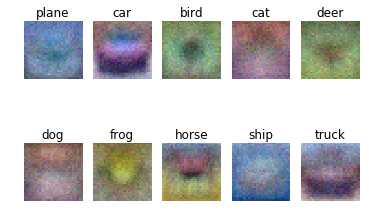

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])